In [1]:
import numpy as np
import torch
import torch.nn as nn
import h5py as h5
import os
import sys
import pickle
from torchdeepretina.models import *
#import metrics
import matplotlib.pyplot as plt
from torchdeepretina.deepretina_loader import loadexpt
from torchdeepretina.physiology import Physio
import torchdeepretina.intracellular as intracellular
import torchdeepretina.batch_compute as bc
import torchdeepretina.retinal_phenomena as rp
import torchdeepretina.stimuli as stimuli
import pyret.filtertools as ft
import scipy
import re
import pickle
from tqdm import tqdm
import gc
import resource
import time
import math
import pandas as pd

def normalize(x):
    return (x-x.mean())/(x.std()+1e-7)

def retinal_phenomena_figs(bn_cnn):
    print("Step Response")
    rp.step_response(bn_cnn)
    plt.show()
    print("OSR")
    rp.osr(bn_cnn, duration=1)
    plt.show()
    print("Reversing Grating")
    rp.reversing_grating(bn_cnn)
    plt.show()
    print("Contrast Adaptation")
    rp.contrast_adaptation(bn_cnn, .35, .05)
    plt.show()
    contrasts = [0.5, 1.2]
#     for i in range(bn_cnn.sequential[-3].weight.shape[0]):
#         rp.contrast_fig(bn_cnn, contrasts, unit_index=i, nonlinearity_type="sigmoid")
    unit = 0
    print("Contrast fig for unit:", unit)
    rp.contrast_fig(bn_cnn, contrasts, unit_index=unit, nonlinearity_type="sigmoid")
    plt.show()
    print("Motion Reversal")
    rp.motion_reversal(bn_cnn)
    plt.show()
    print("Motion Anticipation")
    rp.motion_anticipation(bn_cnn)
    plt.show()
    print("OMS")
    fig, diff_vid, global_vid, diff_response, global_response = rp.oms_differential(bn_cnn)
    plt.show()
    print("Ratios:", global_response.mean(0)/diff_response.mean(0))
    
#If you want to use stimulus that isnt just boxes
def prepare_stim(stim, stim_type):
    if stim_type == 'boxes':
        return 2*stim - 1
    elif stim_type == 'flashes':
        stim = stim.reshape(stim.shape[0], 1, 1)
        return np.broadcast_to(stim, (stim.shape[0], 38, 38))
    elif stim_type == 'movingbar':
        stim = block_reduce(stim, (1,6), func=np.mean)
        stim = pyret.stimulustools.upsample(stim.reshape(stim.shape[0], stim.shape[1], 1), 5)[0]
        return np.broadcast_to(stim, (stim.shape[0], stim.shape[1], stim.shape[1]))
    elif stim_type == 'lines':
        stim_averaged = np.apply_along_axis(lambda m: np.convolve(m, 0.5*np.ones((2,)), mode='same'), 
                                            axis=1, arr=stim)
        stim = stim_averaged[:,::2]
        # now stack stimulus to convert 1d to 2d spatial stimulus
        return stim.reshape(-1,1,stim.shape[-1]).repeat(stim.shape[-1], axis=1)
    else:
        print("Invalid stim type")
        assert False
    
def index_of(arg, arr):
    for i in range(len(arr)):
        if arg == arr[i]:
            return i
    return -1

def make_data_frame(model_stats, headers):
    data = dict()
    for header in headers:
        data[header] = []
    for folder in model_stats.keys():
        untouched_keys = set(data.keys())
        for k in model_stats[folder].keys():
            if k in data:
                data[k].append(model_stats[folder][k])
                if k in untouched_keys:
                    untouched_keys.remove(k)
        with open("../training_scripts/" + folder+"/hyperparams.txt") as f:
            architecture = []
            for i,line in enumerate(f):
                if "(" in line or ")" in line:
                    l = line.replace("\n", "#")
                    architecture.append(l)
                else:
                    splt_line = line.strip().split(":")
                    if len(splt_line) == 2 and splt_line[0].strip() in data:
                        data[splt_line[0].strip()].append(splt_line[1].strip())
                        if splt_line[0].strip() in untouched_keys:
                            untouched_keys.remove(splt_line[0].strip())
            data['architecture'].append("".join(architecture))
            untouched_keys.remove('architecture')
        for k in list(untouched_keys):
            data[k].append(None)
    return pd.DataFrame(data)

def load_model(folder, data):
    try:
        hyps=get_hyps(folder)
        hyps['model_type'] = hyps['model_type'].split(".")[-1].split("\'")[0].strip()
        hyps['model_type'] = globals()[hyps['model_type']]
        bn_cnn = hyps['model_type'](**data['model_hyps'])
    except Exception as e:
        model_hyps = {"n_units":5,"noise":float(hyps['noise'])}
        if "bias" in hyps:
            model_hyps['bias'] = hyps['bias'] == "True"
        if "chans" in hyps:
            model_hyps['chans'] = [int(x) for x in 
                                   hyps['chans'].replace("[", "").replace("]", "").strip().split(",")]
        if "adapt_gauss" in hyps:
            model_hyps['adapt_gauss'] = hyps['adapt_gauss'] == "True"
        if "linear_bias" in hyps:
            model_hyps['linear_bias'] = hyps['linear_bias'] == "True"
        if "softplus" in hyps:
            model_hyps['softplus'] = hyps['softplus'] == "True"
        fn_args = set(hyps['model_type'].__init__.__code__.co_varnames)
        for k in model_hyps.keys():
            if k not in fn_args:
                del model_hyps[k]
        bn_cnn = hyps['model_type'](**model_hyps)
    return bn_cnn

def get_hyps(folder):
    hyps = dict()
    with open(os.path.join("../training_scripts/", folder, "hyperparams.txt")) as f:
        for line in f:
            if "(" not in line and ")" not in line:
                splt = line.strip().split(":")
                if len(splt) > 1:
                    hyps[splt[0]] = splt[1].strip()
    return hyps

In [2]:
DEVICE = torch.device("cuda:0")
torch.cuda.empty_cache()

In [3]:
#Load data
# num_pots stores the number of cells per stimulus
# mem_pots stores the membrane potential
# psst, you can find the "data" folder in /home/grantsrb on deepretina server
# psssst, note the additional ../ added to each path in files
root_path = "~/interneuron_data/"
files = ['bipolars_late_2012.h5', 'bipolars_early_2012.h5', 'amacrines_early_2012.h5', 
         'amacrines_late_2012.h5', 'horizontals_early_2012.h5', 'horizontals_late_2012.h5']
files = [os.path.expanduser(root_path + name) for name in files]
file_ids = []
for f in files:
    file_ids.append(re.split('_|\.', f)[0])
filter_length = 40
window_size = 2
num_pots = []
stims = dict()
mem_pots = dict()
keys_to_use = {"boxes"}
for fi in files:
    with h5.File(fi, 'r') as f:
        for k in f.keys():
            if k in keys_to_use:
                if k not in stims:
                    stims[k] = []
                if k not in mem_pots:
                    mem_pots[k] = []
                try:
                    stims[k].append(prepare_stim(np.asarray(f[k+'/stimuli']), k))
                    mem_pots[k].append(np.asarray(f[k]['detrended_membrane_potential'])[:, filter_length:])
                except:
                    print("stim error at", k)
        num = np.array(f['boxes/detrended_membrane_potential'].shape[0])
        num_pots.append(num)

In [4]:
grand_folder = "absbndatasetsearch"
exp_folder = "../training_scripts/"+grand_folder
_, model_folders, _ = next(os.walk(exp_folder))
for i,f in enumerate(model_folders):
    model_folders[i] = grand_folder + "/" + f
model_folders = sorted(model_folders)
print("\n".join(model_folders))

absbndatasetsearch/absbndatasetsearch_0_dataset15-10-07_lr0.001
absbndatasetsearch/absbndatasetsearch_10_dataset15-11-21b_lr0.001
absbndatasetsearch/absbndatasetsearch_11_dataset15-11-21b_lr0.00075
absbndatasetsearch/absbndatasetsearch_12_dataset15-11-21b_lr0.0005
absbndatasetsearch/absbndatasetsearch_13_dataset15-11-21b_lr0.00025
absbndatasetsearch/absbndatasetsearch_14_dataset15-11-21b_lr0.0001
absbndatasetsearch/absbndatasetsearch_15_dataset15-10-07_lr0.001
absbndatasetsearch/absbndatasetsearch_16_dataset15-10-07_lr0.00075
absbndatasetsearch/absbndatasetsearch_17_dataset15-10-07_lr0.0005
absbndatasetsearch/absbndatasetsearch_18_dataset15-10-07_lr0.00025
absbndatasetsearch/absbndatasetsearch_1_dataset15-10-07_lr0.00075
absbndatasetsearch/absbndatasetsearch_20_dataset15-11-21a_lr0.001
absbndatasetsearch/absbndatasetsearch_21_dataset15-11-21a_lr0.00075
absbndatasetsearch/absbndatasetsearch_22_dataset15-11-21a_lr0.0005
absbndatasetsearch/absbndatasetsearch_23_dataset15-11-21a_lr0.00025


In [5]:
model_folders = ["absbndatasetsearch/absbndatasetsearch_57_dataset15-11-21b_lr0.0009"]

In [6]:
file = "../training_scripts/"+model_folders[0]+"/test_epoch_0.pth"
try:
    with open(file, "rb") as fd:
        temp = torch.load(fd)
except Exception as e:
    print(e)
    pass

try:
    temp['model']
except Exception as e:
    print(e)
    bn_cnn = load_model(model_folders[0], temp)
print(bn_cnn)
try:
    chans = temp['model_hyps']['chans']
    print("Chans:", chans)
except:
    chans = [8, 8]
    print("Chans not recorded in model_hyps. Set to:", chans)

'model'
AbsBNBNCNN(
  (sequential): Sequential(
    (0): Conv2d(40, 8, kernel_size=(15, 15), stride=(1, 1))
    (1): Flatten()
    (2): AbsBatchNorm1d(bias=True, abs_bias=False, momentum=0.01, eps=0.001)
    (3): GaussianNoise(std=0.1, trainable=False, adapt=False, momentum=0.95)
    (4): ReLU()
    (5): Reshape()
    (6): Conv2d(8, 8, kernel_size=(11, 11), stride=(1, 1))
    (7): Flatten()
    (8): AbsBatchNorm1d(bias=True, abs_bias=False, momentum=0.01, eps=0.001)
    (9): GaussianNoise(std=0.1, trainable=False, adapt=False, momentum=0.95)
    (10): ReLU()
    (11): Linear(in_features=5408, out_features=17, bias=False)
    (12): AbsBatchNorm1d(bias=True, abs_bias=False, momentum=0.01, eps=1e-05)
    (13): Softplus(beta=1, threshold=20)
  )
)
Chans: [8, 8]


In [7]:
conv_layers = ['sequential.2', 'sequential.8']

In [8]:
cells = "all"
dataset = '15-10-07'
stim_type = 'naturalscene'
try:
    norm_stats = [temp['norm_stats']['mean'], temp['norm_stats']['std']]
except:
    norm_stats = [51.49175, 53.62663279042969]
test_data = loadexpt(dataset,cells,stim_type,'test',40,0, norm_stats=norm_stats)
test_x = torch.from_numpy(test_data.X)

In [9]:
gc.collect()
max_mem_used = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
print("Memory Used: {:.2f} mb".format(max_mem_used / 1024))

Memory Used: 3152.84 mb


## Look at model performances

In [10]:
n_epochs = 250
batch_compute_size = 500
model_stats = dict()

Using layers: sequential.2 and sequential.8
[Errno 2] No such file or directory: '../training_scripts/absbndatasetsearch/absbndatasetsearch_57_dataset15-11-21b_lr0.0009/test_epoch_200.pth'
[Errno 2] No such file or directory: '../training_scripts/absbndatasetsearch/absbndatasetsearch_57_dataset15-11-21b_lr0.0009/test_epoch_201.pth'
[Errno 2] No such file or directory: '../training_scripts/absbndatasetsearch/absbndatasetsearch_57_dataset15-11-21b_lr0.0009/test_epoch_202.pth'
[Errno 2] No such file or directory: '../training_scripts/absbndatasetsearch/absbndatasetsearch_57_dataset15-11-21b_lr0.0009/test_epoch_203.pth'
[Errno 2] No such file or directory: '../training_scripts/absbndatasetsearch/absbndatasetsearch_57_dataset15-11-21b_lr0.0009/test_epoch_204.pth'
[Errno 2] No such file or directory: '../training_scripts/absbndatasetsearch/absbndatasetsearch_57_dataset15-11-21b_lr0.0009/test_epoch_205.pth'
[Errno 2] No such file or directory: '../training_scripts/absbndatasetsearch/absbndata

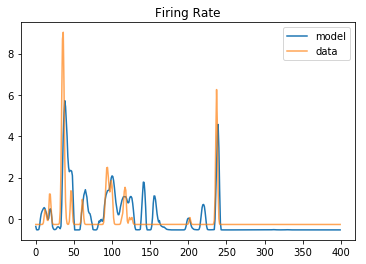

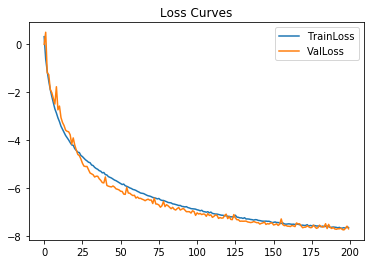

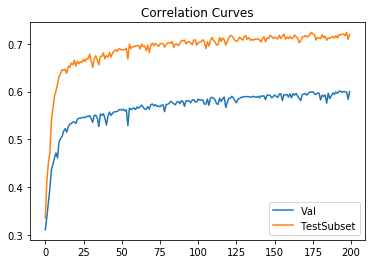

Step Response


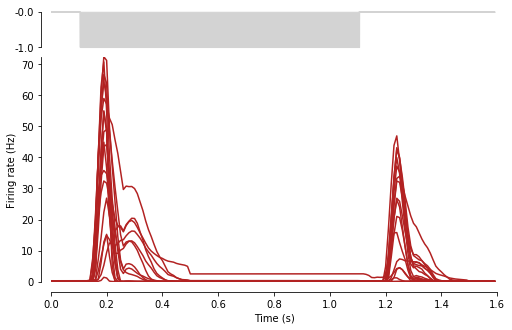

OSR


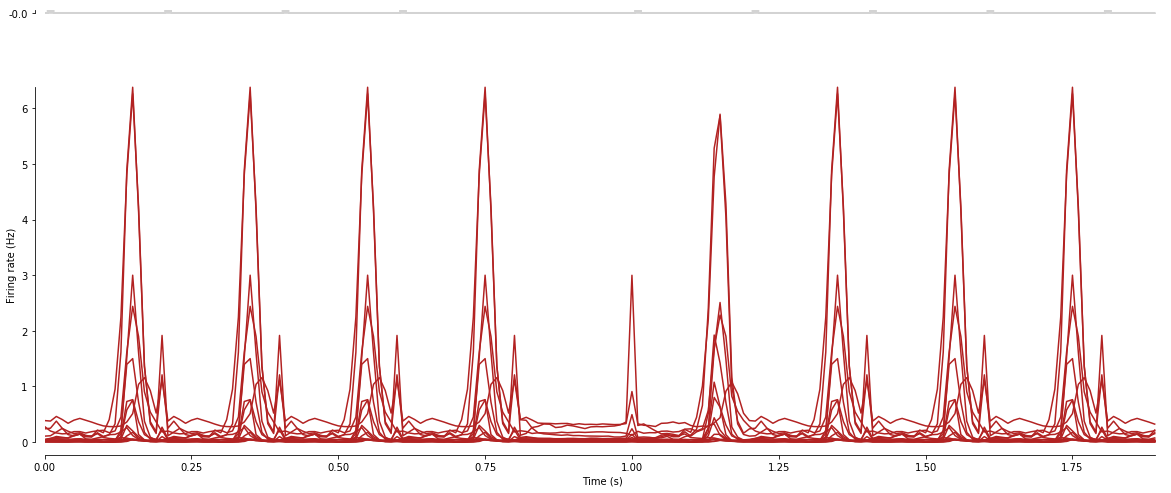

Reversing Grating


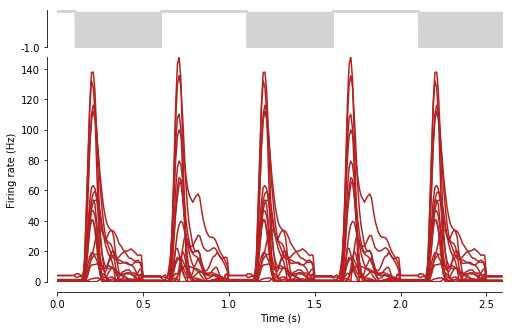

100%|██████████| 10/10 [00:00<00:00, 70.46it/s]

Contrast Adaptation


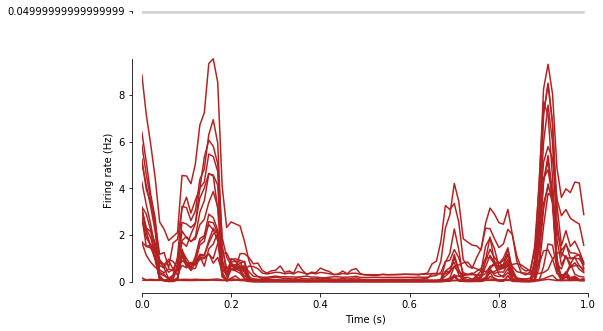

Contrast fig for unit: 0
hook attached to sequential.13
hook detached
Normalizing filter and collecting response
hook attached to sequential.13
hook detached
Normalizing filter and collecting response


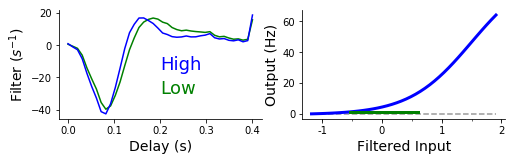

Motion Reversal


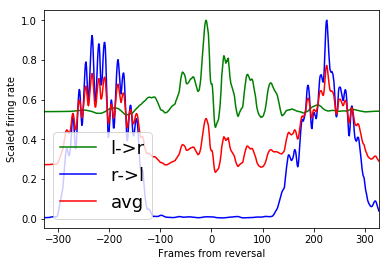

Motion Anticipation


51it [00:00, 229.17it/s]


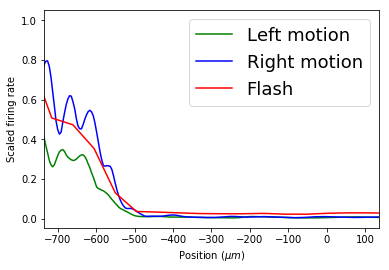

OMS


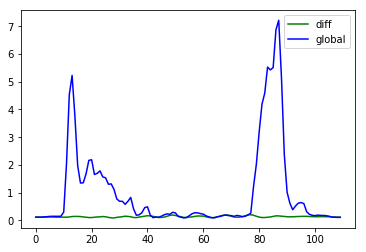

  0%|          | 0/6 [00:00<?, ?it/s]

Ratios: [1.96032227e+03 3.05879879e+00 2.48899221e+00 2.00300479e+00
 1.25335360e+00 1.62962399e+01 3.46545720e+00 1.00397156e+02
 3.72390785e+01 3.40050697e+00 1.46342468e+02 5.45856743e+01
 7.37050018e+01 5.90790796e+00 6.96048660e+01 1.33878307e+01
 1.35562042e+02]
Calculating model responses...



  0%|          | 0/6 [00:00<?, ?it/s]

Calculating intracellular correlations...



 50%|█████     | 3/6 [00:46<00:48, 16.21s/it]

KeyboardInterrupt: 

In [13]:
print("Using layers:", " and ".join(conv_layers))
for folder in model_folders:
    model_stats[folder] = dict()
    starttime = time.time()
    losses = []
    val_losses = []
    val_accs = []
    test_subset_accs = []
    for i in range(n_epochs):
        file = "../training_scripts/"+folder+"/test_epoch_{0}.pth".format(i)
        try:
            with open(file, "rb") as fd:
                data = torch.load(fd)
            losses.append(data['loss'])
            val_losses.append(data['val_loss'])
            val_accs.append(data['val_acc'])
            test_subset_accs.append(data['test_pearson'])
        except Exception as e:
            print(e)
            pass
    try:
        model = data['model']
    except Exception as e:
        model = load_model(folder, data)
    try:
        model.load_state_dict(data['model_state_dict'])
    except RuntimeError as e:
        data['model_state_dict']["sequential.3.sigma"] = data['model_state_dict']["sequential.3.cuda_param"]
        del data['model_state_dict']["sequential.3.cuda_param"]
        data['model_state_dict']["sequential.10.sigma"] = data['model_state_dict']["sequential.10.cuda_param"]
        del data['model_state_dict']["sequential.10.cuda_param"]
        model.load_state_dict(data['model_state_dict'])
    try:
        chans = data['model_hyps']['chans']
    except:
        chans=[8,8]
    model = model.to(DEVICE)
    model.eval()
    print("Folder:", folder)
    print("Final Loss:", losses[-1])
    model_stats[folder]['FinalLoss'] = losses[-1]
    print("Final Val:", val_losses[-1])
    model_stats[folder]['FinalVal'] = val_losses[-1]
    print("Final Val Acc:", val_accs[-1])
    model_stats[folder]['ValAcc'] = val_accs[-1]
    if(math.isnan(losses[-1]) or math.isnan(val_losses[-1]) or math.isnan(val_accs[-1])):
        print("NaN results, continuing...\n\n\n\n")
        continue

    model_response = bc.batch_compute_model_response(test_data.X, model, batch_compute_size, 
                                                     insp_keys=set(conv_layers))
    test_accs = [scipy.stats.pearsonr(model_response['output'][:, i], test_data.y[:, i])[0] 
                                                    for i in range(test_data.y.shape[-1])]
    avg_test_acc = np.mean(test_accs)
    for i, cell in enumerate(test_data.cells):
        model_stats[folder]["cell"+str(cell)] = test_accs[i]
    if math.isnan(avg_test_acc):
        print("NaN results, continuing...\n\n\n\n")
        continue
    print("\nFinal Test Acc:", avg_test_acc)
    model_stats[folder]['FinalTestAcc'] = avg_test_acc
    with open("../training_scripts/"+folder+"/hyperparams.txt", 'a') as f:
        f.write("\nTest Ganglion Cell Correlation: " + str(avg_test_acc))
    # Traces
    plt.plot(normalize(model_response['output'][:400, 0]))
    plt.plot(normalize(test_data.y[:400,0]), alpha=.7)
    plt.legend(["model", "data"])
    plt.title("Firing Rate")
    plt.show()
    # Loss curves
    plt.plot(losses)
    plt.plot(val_losses)
    plt.legend(["TrainLoss", "ValLoss"])
    plt.title("Loss Curves")
    plt.show()
    # Correlations
    plt.plot(val_accs)
    plt.plot(test_subset_accs)
    plt.legend(["Val", "TestSubset"])
    plt.title("Correlation Curves")
    plt.show()
    retinal_phenomena_figs(model)
    plt.show()
    
    if avg_test_acc < .4 or losses[-1] > 1:
        print("Skipping further analysis due to poor results...\n\n\n\n")
        continue
    print("Calculating model responses...\n")
    # Computes the model responses for each stimulus 
    # and interneuron type labels y_true (0 for bipolar, 1 for amacrine, 2 for horizontal)
    y_true = []
    filter_length = 40
    model_responses = dict()
    for i in tqdm(range(len(files))):
        file_name = files[i]
        if 'bipolar' in file_name:
            for j in range(num_pots[i]):
                y_true.append(0)
        elif 'amacrine' in file_name:
            for j in range(num_pots[i]):
                y_true.append(1)
        else:
            for j in range(num_pots[i]):
                y_true.append(2)
        for k in stims.keys():
            stim = stims[k][i]
            padded_stim = intracellular.pad_to_edge(scipy.stats.zscore(stim))
            if k not in model_responses:
                model_responses[k] = []
            model_responses[k].append(bc.batch_compute_model_response(stimuli.concat(padded_stim),
                                                                      model,batch_compute_size, 
                                                                      insp_keys=set(conv_layers)))
            # Reshape potentially flat layers
            for j,cl in enumerate(conv_layers):
                if len(model_responses[k][-1][cl].shape) <= 2:
                    try:
                        model_responses[k][-1][cl] = model_responses[k][-1][cl].reshape((-1,chans[0],36,36))
                    except:
                        model_responses[k][-1][cl] = model_responses[k][-1][cl].reshape((-1,chans[1],26,26))
    
    # uses classify to get the most correlated cell/layer/subtype for each interneuron recording. 
    # Stored in all_cell_info. y_pred does a baseline "classification": record the convolutional 
    # layer that the most correlated cell is in.
    # See intracellular.py for more info
    # y_pred holds the layer that was maximally correlated between the conv_layers 
    print("Calculating intracellular correlations...\n")
    all_cell_info = dict()
    y_pred = dict()
    for i in tqdm(range(len(files))):
        for k in stims.keys():
            model_response = model_responses[k][i]
            stim = stims[k][i]
            for j in range(mem_pots[k][i].shape[0]):
                potential = mem_pots[k][i][j]
                cell_info = intracellular.classify(potential, model_response, stim.shape[0], 
                                                   layer_keys=conv_layers)
                #layer, channel,(row, col), cor_coef = cell_info
                if k not in all_cell_info:
                    all_cell_info[k] = []
                    y_pred[k] = []
                all_cell_info[k].append(cell_info)
                y_pred[k].append(index_of(cell_info[0], conv_layers))
    
    model_stats[folder]['all_cell_info'] = all_cell_info
    
    # Collect intracellular correlations 
    cell_types = ["bipolar", "amacrine", "horizontal"]
    idx_to_cell = {i:t for i,t in enumerate(cell_types)}
    cors = {"bipolar":[], "amacrine":[], "horizontal":[]}
    for i in range(len(y_true)):
        idx = y_true[i]
        cell_type = idx_to_cell[idx]
        # Add correlations from all stimulus types for this particular interneuron
        cors[cell_type].extend([all_cell_info[k][i][-1] for k in all_cell_info.keys()])
    # Collect average correlation coefficient for each cell type
    for key in cors.keys():
        model_stats[folder][key+"_intr_cor"] = np.mean(cors[key])
        print(key, "intracellular:", model_stats[folder][key+"_intr_cor"])
        
    # Average intracellular correlation. RIP.
    avg_intr_cor = np.mean(np.asarray([[all_cell_info[k][i][-1] for i in range(len(all_cell_info[k]))] for k in all_cell_info.keys()]))
    print("Mean intracellular:", avg_intr_cor)
    model_stats[folder]['Meanintracellular'] = avg_intr_cor
    std = np.std(np.asarray([[all_cell_info[k][i][-1] for i in range(len(all_cell_info[k]))] for k in all_cell_info.keys()]))
    print("Std intracellular:", std)
    m = np.min(np.asarray([[all_cell_info[k][i][-1] for i in range(len(all_cell_info[k]))] for k in all_cell_info.keys()]))
    print("Min intracellular:", m)
    model_stats[folder]["Minintracellular"] = m
    m = np.max(np.asarray([[all_cell_info[k][i][-1] for i in range(len(all_cell_info[k]))] for k in all_cell_info.keys()]))
    print("Max intracellular:", m)
    model_stats[folder]["Maxintracellular"] = m
    
    stim_type = 'boxes'
    # Make example correlation map
    model_response = model_responses[stim_type][-1]
    potential = mem_pots[stim_type][-1][-1]
    layer, k, (i,j), r = all_cell_info[stim_type][-1]
    print("Layer", layer, "correlation map")
    plt.imshow(intracellular.correlation_map(potential, model_response[layer][:, k]))
    plt.show()

    keys = cell_types
    layer_dict = {}
    # Tally layers for maximally correlated cell
    # y_true holds the true neuron type for each interneuron (0 is bipolar, 1 is amacrine, 2 is horizontal)
    for i in range(len(y_true)):
        if y_true[i] not in layer_dict:
            layer_dict[y_true[i]] = [0 for i in range(len(conv_layers))]
        for k in y_pred.keys():
            layer_dict[y_true[i]][y_pred[k][i]] += 1 # tallys for each neuron type the layer of max correlation

    width = 0.5
    lkeys = list(layer_dict.keys())
    ind = np.arange(0,len(conv_layers))
    for i,k in enumerate(lkeys):
        plt.bar(ind, [count for count in layer_dict[k]], width)
        plt.xticks(ind,conv_layers)
        print(keys[i])
        plt.title("Layer of unit with max correlation")
        plt.show()
    
#     layer_dict = {keys[k]:v for k,v in layer_dict.items()}
#     # layer dict now is {"bipolar":[layer1count, layer2count], "amacrine":...}
#     model_stats[folder]['max_cor_layer_tallys'] = layer_dict
    
    stimulus_num = 3
    filter_length = 40
    for type_key in stims.keys():
        if type_key == "flashes":
            continue
        stimulus = stims[type_key][stimulus_num]
        # Plot the receptive field for a model cell
        for i,cl in enumerate(conv_layers):
            model_cell_response = model_responses[type_key][stimulus_num][cl][:, 1, 15, 15]
            print("Receptive field of", type_key,"model cell in Layer", i)
            rc_model, lags_model = ft.revcorr(scipy.stats.zscore(stimulus)[filter_length:], model_cell_response, 
                                              nsamples_before=0, nsamples_after=filter_length)
            spatial_model, temporal_model = ft.decompose(rc_model)
            img = plt.imshow(spatial_model, cmap = 'seismic', clim=[-np.max(abs(spatial_model)), 
                                                                   np.max(abs(spatial_model))])
            plt.show()
    
    gc.collect()
    max_mem_used = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
    print("Memory Used: {:.2f} memory".format(max_mem_used / 1024))
    print("Completed in", time.time()-starttime, "seconds")
    print("\n\n\n\n")

## Analyze Performances

In [ ]:
models_csv = 'models.csv'

In [ ]:
with open('models.csv') as f:
    headers = f.readline().strip().split("!")

In [ ]:
### Add headers
# head_set = set(headers)
# missing_keys = set()
# for folder in model_stats.keys():
#     model_hyps = get_hyps(folder)
#     for k in model_hyps.keys():
#         if k not in head_set:
#             missing_keys.add(k)
# missing_keys
# headers.append('bnorm_momentum')
# headers.append('linear_bias')

# main_frame = pd.read_csv(models_csv, delimiter="!")
# main_frame = main_frame.reindex(headers, axis=1)
# main_frame.to_csv(models_csv, header=True, mode='w', sep="!", index=False)

In [ ]:
pdframe = make_data_frame(model_stats, headers)

In [ ]:
cols = ["exp_num", "lr", "l1", "l2", "noise", "adapt_gauss", "bias", "linear_bias", "chans", "lossfxn", "FinalTestAcc", "Meanintracellular"]

In [ ]:
frame = pdframe.loc[:, cols]
frame.sort_values(by="FinalTestAcc", ascending=False)

### Write to comprehensive model csv

In [ ]:
pdframe = pdframe.reindex(headers, axis=1)

In [ ]:
pdframe

In [ ]:
pdframe.to_csv(models_csv, header=False, mode='a', sep="!", index=False)